## Loading Dataset and Preprocessing

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
from skimage.feature import hog
from skimage import color
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import euclidean_distances
from collections import Counter
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import rand_score
from sklearn.svm import SVC
from skimage.feature import local_binary_pattern


# Load Caltech-101 Dataset
print("Loading Caltech-101 dataset...")
dataset, info = tfds.load("caltech101", with_info=True, as_supervised=True)

# Preprocess Data: Resize images and collect labels
def preprocess_data(dataset, image_size=(128, 128)):
    images, labels = [], []
    # Iterate through the 'train' and 'test' splits of the dataset
    for split_name in ['train', 'test']:  # Iterate over split names
        split = dataset[split_name]  # Get the actual split using the name
        for image, label in tfds.as_numpy(split): 
            resized_image = cv2.resize(image, image_size)  # Resize to a fixed size
            images.append(resized_image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Preprocess the full dataset
print("Preprocessing the dataset...")
x_full, y_full = preprocess_data(dataset)
print(f"x_full shape: {x_full.shape}, y_full shape: {y_full.shape}")

# Split the dataset into training and testing with custom ratio
train_percentage = 0.8  # Adjust this value to control the split ratio
x_train, x_test, y_train, y_test = train_test_split(
    x_full, y_full, test_size=1 - train_percentage, random_state=42
)
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")


Loading Caltech-101 dataset...
Preprocessing the dataset...
x_full shape: (9144, 128, 128, 3), y_full shape: (9144,)
x_train shape: (7315, 128, 128, 3), y_train shape: (7315,)
x_test shape: (1829, 128, 128, 3), y_test shape: (1829,)


## HOG 

### HOG Visualization


HOG features size: (1764,)


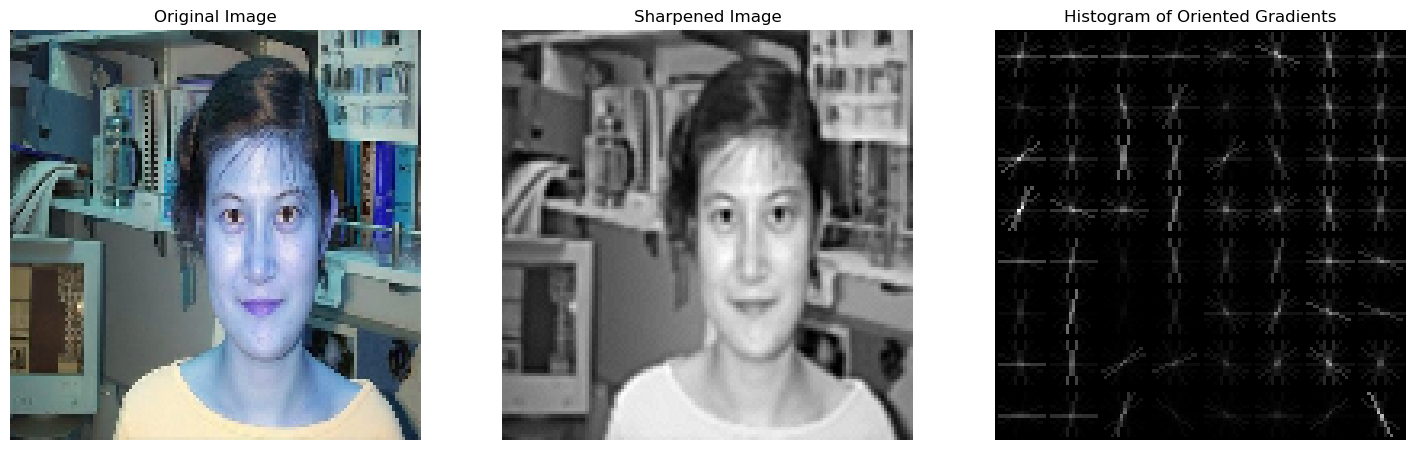

In [406]:
# Function to visualize HOG with skimage
def visualize_hog_with_skimage(image, pixels_per_cell=(16, 16), cells_per_block=(2, 2), orientations=9):
    """
    Visualizes the original image and its HOG representation.
    Uses skimage for accurate HOG visualization.
    """
    hog_features, hog_image = hog(
        image,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        visualize=True,
        channel_axis=None  # Explicitly state there is no channel axis
    )
    print(f"HOG features size: {hog_features.shape}")
    return hog_image

# Select a random image
random_idx = np.random.randint(0, len(x_train))
random_image = x_train[random_idx]

# Convert to grayscale
gray_image = cv2.cvtColor(random_image, cv2.COLOR_RGB2GRAY)

# Apply Gaussian filter for smoothing
def apply_gaussian_filter(image, kernel_size=(5, 5), sigma=1):
    return cv2.GaussianBlur(image, kernel_size, sigma)

# Sharpening function
def sharpen_image(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)

# Smooth and sharpen the grayscale image
smoothed_image = apply_gaussian_filter(gray_image)
sharpened_image = sharpen_image(smoothed_image)

# Extract HOG features and get the visualization
hog_visualization = visualize_hog_with_skimage(sharpened_image)

# Plot all three images
plt.figure(figsize=(18, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

# Sharpened Image
plt.subplot(1, 3, 2)
plt.title("Sharpened Image")
plt.imshow(sharpened_image, cmap="gray")
plt.axis("off")

# HOG Visualization
plt.subplot(1, 3, 3)
plt.title("Histogram of Oriented Gradients")
plt.imshow(hog_visualization, cmap="gray")
plt.axis("off")

plt.show()

### HOG Extraction

In [7]:
# Apply Gaussian filter for smoothing
def apply_gaussian_filter(image, kernel_size=(5, 5), sigma=1):
    return cv2.GaussianBlur(image, kernel_size, sigma)

# Sharpening function
def sharpen_image(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)
    
def extract_hog_with_skimage(image, pixels_per_cell=(16, 16), cells_per_block=(2, 2), orientations=9):
    """
    Extracts HOG features from an image using skimage.
    """
    # Convert the image to grayscale if it's not already
    if len(image.shape) == 3:  # Check if it's RGB (3 channels)
        gray_image = color.rgb2gray(image)
    else:
        gray_image = image  # It's already in grayscale, no need to convert

    smoothed_image = apply_gaussian_filter(gray_image)  # Apply Gaussian filter
    sharpened_image = sharpen_image(smoothed_image)

    # Compute HOG features
    hog_features = hog(
        sharpened_image,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        visualize=False,  # Do not return visualization
        block_norm='L2-Hys'  # Use L2-Hys normalization (often better performance)
    )
    
    return hog_features

# Extract HOG features
print("Extracting HOG features...")
hog_features_train = np.array([extract_hog_with_skimage(img) for img in x_train])
hog_features_test = np.array([extract_hog_with_skimage(img) for img in x_test])
print(f"HOG feature extraction complete! Feature shape: {hog_features_train[0].shape}")
print(f"HOG feature extraction complete! Feature shape: {hog_features_test[0].shape}")


Extracting HOG features...
HOG feature extraction complete! Feature shape: (1764,)
HOG feature extraction complete! Feature shape: (1764,)


### KNN 

In [412]:
# KNN Classifier (Implemented from Scratch)
def knn_classifier(train_data, train_labels, test_data, k=5):
    predictions = []
    for test_point in test_data:
        distances = np.linalg.norm(train_data - test_point, axis=1)
        nearest_indices = np.argsort(distances)[:k]
        nearest_labels = train_labels[nearest_indices]
        unique, counts = np.unique(nearest_labels, return_counts=True)
        predictions.append(unique[np.argmax(counts)])
    return np.array(predictions)


# Run KNN
print("Running KNN...")
knn_predictions = knn_classifier(hog_features_train, y_train, hog_features_test, k=5)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN Accuracy:", knn_accuracy)

Running KNN...
KNN Accuracy: 0.49589939857845816


### K-means

In [11]:
def k_means_clustering(data, k=101, max_iters=100 ,tol=1e-4):
    # 1. Initialize centroids randomly
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    for i in range(max_iters):
        # 2. Assign each data point to the nearest centroid
        distances = euclidean_distances(data, centroids)
        labels = np.argmin(distances, axis=1)
        # 3. Update centroids to the mean of the assigned data points
        new_centroids = np.array([data[labels == i].mean(axis=0)
                                  if np.any(labels == i) else centroids[i]
                                  for i in range(k)])
        # Step 3.4: Check for convergence (if centroids do not change significantly)
        centroid_shift = np.linalg.norm(new_centroids - centroids)
        if centroid_shift < tol:
            print(f"Converged after {i+1} iterations")
            break
        centroids = new_centroids
    return labels, centroids

# Run K-Means
print("Running K-Means...")
kmeans_labels, centroids = k_means_clustering(hog_features_train, k=101)

cluster_mapping = {}
for i in range(101):
    cluster_labels = y_train[kmeans_labels == i]
    if cluster_labels.size > 0:
        most_common_label = Counter(cluster_labels).most_common(1)[0][0]
        cluster_mapping[i] = most_common_label

# Predict labels for test data using the trained centroids
distances = euclidean_distances(hog_features_test, centroids)
kmeans_predictions = np.argmin(distances, axis=1)  # Assign cluster labels based on closest centroid
remapped_predictions = [cluster_mapping.get(label, 'unknown') for label in kmeans_predictions]

correct_predictions = sum(y_pred == y_true for y_pred, y_true in zip(remapped_predictions, y_test))
total_predictions = len(y_test)
accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy * 100:.2f}%")

# ari = adjusted_rand_score(y_test, kmeans_predictions)
# print(f"Adjusted Rand Index: {ari}")

# ri = rand_score(y_test, kmeans_predictions)
# print(f"Rand Index: {ri}")


Running K-Means...
Converged after 22 iterations
Accuracy: 43.14%


### SVM

In [410]:
# SVM Classifier (Using Scikit-learn)
print("Training SVM...")
svm = SVC(kernel='linear')
svm.fit(hog_features_train, y_train)
svm_predictions = svm.predict(hog_features_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)

Training SVM...
SVM Accuracy: 0.647348277747403


## Color Histogram 

### Color Histogram Extraction

In [13]:
# Feature Extraction Functions
def extract_color_histogram_features(image, bins=(256,256,256)):
    """
    Extract color histogram features for the given image.
    Features are computed for each channel and concatenated.
    """
    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
   # Calculate histograms for H, S, and V channels
    hist_h = cv2.calcHist([hsv_image], [0], None, [bins[0]], [0, 180]).flatten()  # Hue: 0-180 in OpenCV
    hist_s = cv2.calcHist([hsv_image], [1], None, [bins[1]], [0, 256]).flatten()  # Saturation: 0-255
    hist_v = cv2.calcHist([hsv_image], [2], None, [bins[2]], [0, 256]).flatten()  # Value: 0-255
    
    color_hist = np.concatenate((hist_h, hist_s, hist_v))
    
    # Concatenate histograms into a single feature vector
    return color_hist

# Extract Color Histogram Features
print("Extracting color histogram features...")
hist_features_train = np.array([extract_color_histogram_features(img) for img in x_train])
hist_features_test = np.array([extract_color_histogram_features(img) for img in x_test])
print(f"Color histogram feature extraction complete! Feature shape: {hist_features_train[0].shape}")

Extracting color histogram features...
Color histogram feature extraction complete! Feature shape: (768,)


### Visualization

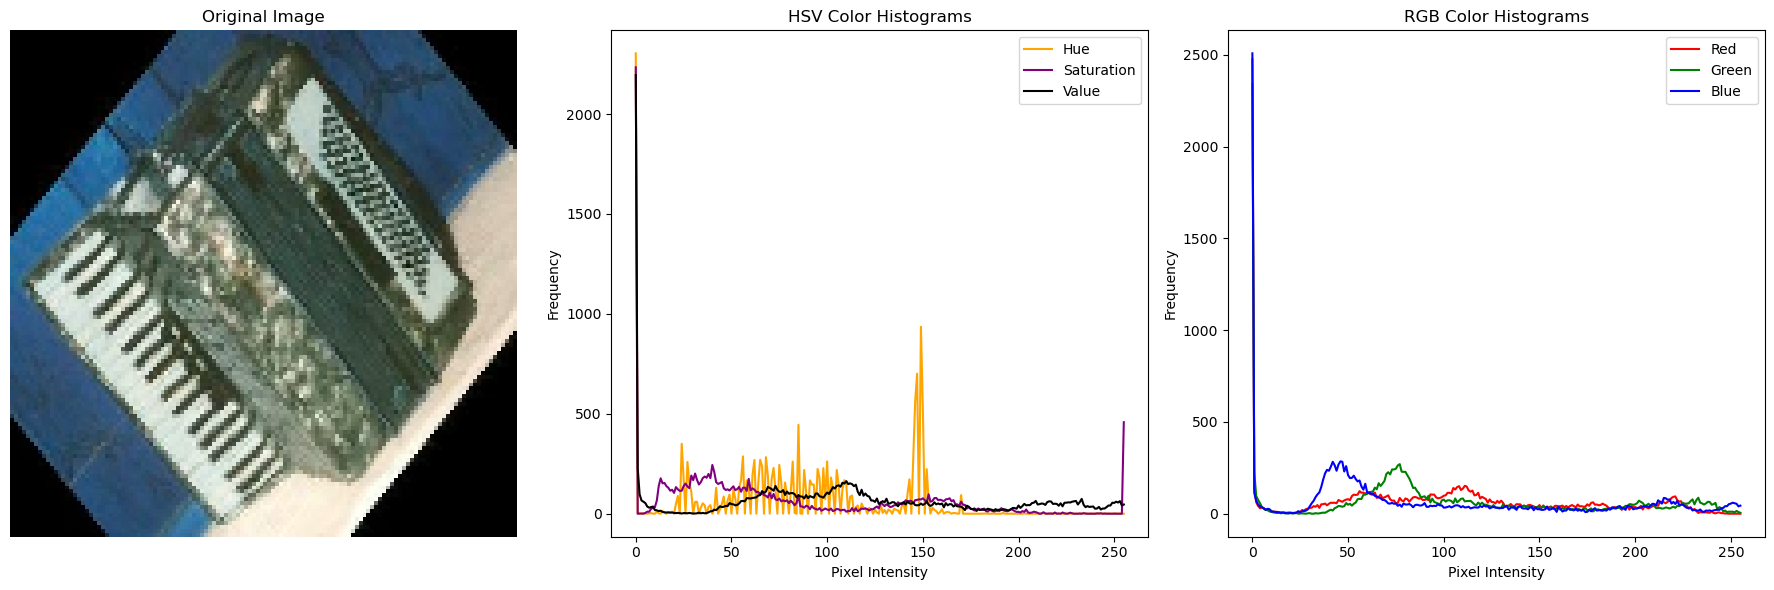

Extracted HSV histogram feature shape: (768,)


In [307]:
# Feature Extraction Function for Color Histograms in HSV Space
def extract_color_histogram_features(image, bins=(256, 256, 256)):
    """
    Extract color histogram features for the given image.
    Features are computed for each channel (Hue, Saturation, and Value in HSV space)
    and then concatenated into a single feature vector.
    """
    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Calculate histograms for Hue (H), Saturation (S), and Value (V) channels
    hist_h = cv2.calcHist([hsv_image], [0], None, [bins[0]], [0, 180]).flatten()  # Hue: 0-180 in OpenCV
    hist_s = cv2.calcHist([hsv_image], [1], None, [bins[1]], [0, 256]).flatten()  # Saturation: 0-255
    hist_v = cv2.calcHist([hsv_image], [2], None, [bins[2]], [0, 256]).flatten()  # Value: 0-255
    
    # Concatenate the histograms of H, S, and V into a single feature vector
    color_hist = np.concatenate((hist_h, hist_s, hist_v))
    
    return color_hist

# Select a random image from the training set
random_index = np.random.randint(len(x_train))  # Choose a random index from the training set
random_image = x_train[random_index]

# Extract color histogram features using the HSV-based function
hist_features = extract_color_histogram_features(random_image)

# Convert the random image to HSV color space for visualization
random_image_hsv = cv2.cvtColor(random_image, cv2.COLOR_BGR2HSV)

# Extract histograms for H, S, and V channels for visualization using the extract function
hist_h = hist_features[:256]  # Hue: 0-180
hist_s = hist_features[256:512]  # Saturation: 0-255
hist_v = hist_features[512:]  # Value: 0-255

# Extract RGB color histograms for visualization
hist_r = cv2.calcHist([random_image], [0], None, [256], [0, 256]).flatten()  # Red: 0-255
hist_g = cv2.calcHist([random_image], [1], None, [256], [0, 256]).flatten()  # Green: 0-255
hist_b = cv2.calcHist([random_image], [2], None, [256], [0, 256]).flatten()  # Blue: 0-255

# Plot the original image and its color histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original Image
axes[0].imshow(cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
axes[0].set_title("Original Image")
axes[0].axis('off')  # Hide axes

# HSV Color Histogram (H, S, V)
axes[1].plot(hist_h, color='orange', label='Hue')
axes[1].plot(hist_s, color='purple', label='Saturation')
axes[1].plot(hist_v, color='black', label='Value')
axes[1].set_title("HSV Color Histograms")
axes[1].set_xlabel("Pixel Intensity")
axes[1].set_ylabel("Frequency")
axes[1].legend()

# RGB Color Histogram (R, G, B)
axes[2].plot(hist_r, color='red', label='Red')
axes[2].plot(hist_g, color='green', label='Green')
axes[2].plot(hist_b, color='blue', label='Blue')
axes[2].set_title("RGB Color Histograms")
axes[2].set_xlabel("Pixel Intensity")
axes[2].set_ylabel("Frequency")
axes[2].legend()

plt.tight_layout()
plt.show()

# Print feature shape (you can use the feature vector for classification later)
print(f"Extracted HSV histogram feature shape: {hist_features.shape}")


### KNN

In [269]:
# KNN Classifier (Implemented from Scratch)
def knn_classifier(train_data, train_labels, test_data, k=5):
    predictions = []
    for test_point in test_data:
        distances = np.linalg.norm(train_data - test_point, axis=1)
        nearest_indices = np.argsort(distances)[:k]
        nearest_labels = train_labels[nearest_indices]
        unique, counts = np.unique(nearest_labels, return_counts=True)
        predictions.append(unique[np.argmax(counts)])
    return np.array(predictions)


# Run KNN
print("Running KNN...")
knn_predictions = knn_classifier(hist_features_train, y_train, hist_features_test, k=5)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN Accuracy:", knn_accuracy)

Running KNN...
KNN Accuracy: 0.2974302897758338


### K-means

In [15]:
def k_means_clustering(data, k=101, max_iters=100 ,tol=1e-4):
    # 1. Initialize centroids randomly
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    for i in range(max_iters):
        # 2. Assign each data point to the nearest centroid
        distances = euclidean_distances(data, centroids)
        labels = np.argmin(distances, axis=1)
        # 3. Update centroids to the mean of the assigned data points
        new_centroids = np.array([data[labels == i].mean(axis=0)
                                  if np.any(labels == i) else centroids[i]
                                  for i in range(k)])
        # Step 3.4: Check for convergence (if centroids do not change significantly)
        centroid_shift = np.linalg.norm(new_centroids - centroids)
        if centroid_shift < tol:
            print(f"Converged after {i+1} iterations")
            break
        centroids = new_centroids
    return labels, centroids

# Run K-Means
print("Running K-Means...")
kmeans_labels, centroids = k_means_clustering(hist_features_train, k=101)

cluster_mapping = {}
for i in range(101):
    cluster_labels = y_train[kmeans_labels == i]
    if cluster_labels.size > 0:
        most_common_label = Counter(cluster_labels).most_common(1)[0][0]
        cluster_mapping[i] = most_common_label

# Predict labels for test data using the trained centroids
distances = euclidean_distances(hist_features_test, centroids)
kmeans_predictions = np.argmin(distances, axis=1)  # Assign cluster labels based on closest centroi
remapped_predictions = [cluster_mapping.get(label, 'unknown') for label in kmeans_predictions]

correct_predictions = sum(y_pred == y_true for y_pred, y_true in zip(remapped_predictions, y_test))
total_predictions = len(y_test)
accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy * 100:.2f}%")

# ari = adjusted_rand_score(y_test, kmeans_predictions)
# print(f"Adjusted Rand Index: {ari}")

# ari2 = rand_score(y_test, kmeans_predictions)
# print(f"Rand Index: {ari2}")


Running K-Means...
Converged after 37 iterations
Accuracy: 24.71%


### SVM

In [369]:
# SVM Classifier (Using Scikit-learn)
print("Training SVM...")
svm = SVC(kernel='linear')
svm.fit(hist_features_train, y_train)
svm_predictions = svm.predict(hist_features_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)


Training SVM...
SVM Accuracy: 0.2793876435210498


## LBP

### LBP Extraction

In [17]:
# Feature Extraction: Local Binary Patterns (LBP) Histogram with Block Division
def extract_lbp_features(image, num_points=24, radius=5, bins=256, block_size=(32, 32)):
    """
    Extract LBP histogram features from the image, divided into blocks.
    Arguments:
        image: Input image in RGB format.
        num_points: Number of points for LBP calculation.
        radius: Radius for LBP calculation.
        bins: Number of bins for the histogram.
        block_size: Tuple indicating block size (height, width) to divide the image.
    Returns:
        Flattened LBP histogram feature vector after block division.
    """
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Get the image dimensions
    img_height, img_width = gray.shape
    
    # Initialize an empty list to store the histograms for each block
    lbp_histograms = []
    
    # Divide the image into blocks and compute LBP for each block
    block_height, block_width = block_size
    for y in range(0, img_height, block_height):
        for x in range(0, img_width, block_width):
            # Define the block region
            block = gray[y:y+block_height, x:x+block_width]
            
            # Compute LBP for the block
            lbp = local_binary_pattern(block, num_points, radius, method='uniform')
            
            # Compute the histogram of LBP values for this block
            hist, _ = np.histogram(lbp.ravel(), bins=bins, range=(0, bins))
            
            # Normalize the histogram
            lbp_histograms.append(hist / hist.sum())
    
    # Concatenate the histograms of all blocks into a single feature vector
    return np.concatenate(lbp_histograms)

# Extract LBP features for the training and test sets
print("Extracting LBP features with block division...")
lbp_features_train = np.array([extract_lbp_features(img) for img in x_train])
lbp_features_test = np.array([extract_lbp_features(img) for img in x_test])
print(f"LBP feature extraction complete! Feature shape: {lbp_features_train[0].shape}")

Extracting LBP features with block division...
LBP feature extraction complete! Feature shape: (4096,)


### Visualization

Visualizing LBP transformation...


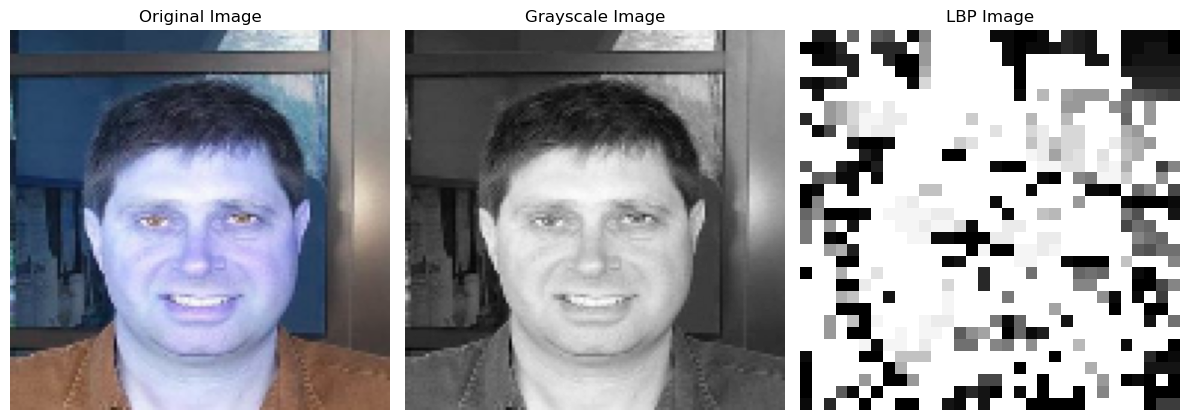

In [363]:
# Feature Extraction: Local Binary Patterns (LBP) Histogram
def extract_and_visualize_lbp(image, num_points=24, radius=5, bins=256, block_size=(32, 32)):
    """
    Extract and visualize LBP for a given image.
    Arguments:
        image: Input image in RGB format.
        num_points: Number of points for LBP calculation.
        radius: Radius for LBP calculation.
        bins: Number of bins for the histogram.
    Returns:
        LBP image and histogram features.
    """
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Get the image dimensions
    img_height, img_width = gray.shape
    
    # Initialize an empty list to store the histograms for each block
    lbp_histograms = []
    
    # Divide the image into blocks and compute LBP for each block
    block_height, block_width = block_size
    for y in range(0, img_height, block_height):
        for x in range(0, img_width, block_width):
            # Define the block region
            block = gray[y:y+block_height, x:x+block_width]
            
            # Compute LBP for the block
            lbp = local_binary_pattern(block, num_points, radius, method='uniform')
            
            # Compute the histogram of LBP values for this block
            hist, _ = np.histogram(lbp.ravel(), bins=bins, range=(0, bins))
            # Normalize the histogram
            lbp_histograms.append(hist / hist.sum())
            
    
    hist_normalized = np.concatenate(lbp_histograms)

    # Visualization
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    # Grayscale Image
    plt.subplot(1, 3, 2)
    plt.title("Grayscale Image")
    plt.imshow(gray, cmap='gray')
    plt.axis("off")

    # LBP Image
    plt.subplot(1, 3, 3)
    plt.title("LBP Image")
    plt.imshow(lbp, cmap='gray')
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return lbp, hist_normalized

# Select a random image from the dataset
random_idx = np.random.randint(0, len(x_train))
random_image = x_train[random_idx]

# Apply LBP and visualize
print("Visualizing LBP transformation...")
lbp_image, lbp_histogram = extract_and_visualize_lbp(random_image)


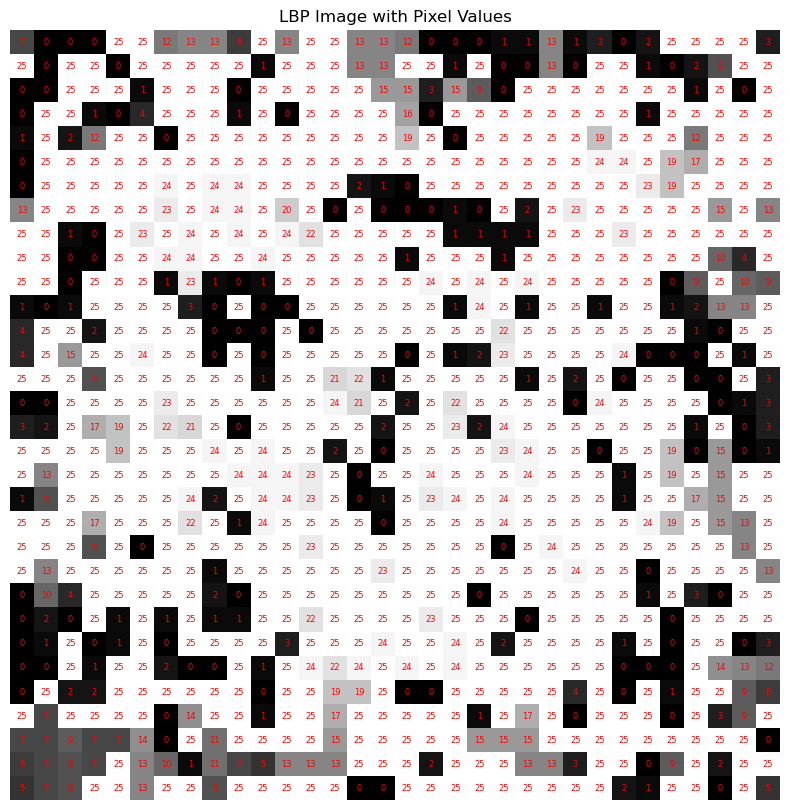

In [365]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

def visualize_lbp_with_matrix(image, num_points=24, radius=5, block_size=(32, 32)):
    """
    Visualize the LBP image alongside its pixel intensity matrix.
    Arguments:
        image: Input image in RGB format.
        num_points: Number of points for LBP calculation.
        radius: Radius for LBP calculation.
    """
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Get the image dimensions
    img_height, img_width = gray.shape
    
    
    # Divide the image into blocks and compute LBP for each block
    block_height, block_width = block_size
    for y in range(0, img_height, block_height):
        for x in range(0, img_width, block_width):
            # Define the block region
            block = gray[y:y+block_height, x:x+block_width]
            
            # Compute LBP for the block
            lbp = local_binary_pattern(block, num_points, radius, method='uniform')

    # Create a figure with subplots
    fig, ax = plt.subplots(figsize=(10, 10))

    # Display the LBP image
    ax.imshow(lbp, cmap='gray')
    ax.set_title("LBP Image with Pixel Values")

    # Annotate pixel values on the image
    for i in range(lbp.shape[0]):
        for j in range(lbp.shape[1]):
            ax.text(j, i, f"{int(lbp[i, j])}", color="red", ha="center", va="center", fontsize=6)

    # Remove axis for clarity
    ax.axis("off")
    plt.show()

# Select a random image from the dataset
random_idx = np.random.randint(0, len(x_train))
random_image = x_train[random_idx]

# Visualize LBP image with pixel values
visualize_lbp_with_matrix(random_image)


### KNN

In [319]:
# KNN Classifier (Implemented from Scratch)
def knn_classifier(train_data, train_labels, test_data, k=5):
    predictions = []
    for test_point in test_data:
        distances = np.linalg.norm(train_data - test_point, axis=1)
        nearest_indices = np.argsort(distances)[:k]
        nearest_labels = train_labels[nearest_indices]
        unique, counts = np.unique(nearest_labels, return_counts=True)
        predictions.append(unique[np.argmax(counts)])
    return np.array(predictions)

# Run KNN
print("Running KNN...")
knn_predictions = knn_classifier(lbp_features_train, y_train, lbp_features_test, k=5)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN Accuracy:", knn_accuracy)

Running KNN...
KNN Accuracy: 0.33460907599781303


### K-means

In [19]:
def k_means_clustering(data, k=101, max_iters=100 ,tol=1e-4):
    # 1. Initialize centroids randomly
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    for i in range(max_iters):
        # 2. Assign each data point to the nearest centroid
        distances = euclidean_distances(data, centroids)
        labels = np.argmin(distances, axis=1)
        # 3. Update centroids to the mean of the assigned data points
        new_centroids = np.array([data[labels == i].mean(axis=0)
                                  if np.any(labels == i) else centroids[i]
                                  for i in range(k)])
        # Step 3.4: Check for convergence (if centroids do not change significantly)
        centroid_shift = np.linalg.norm(new_centroids - centroids)
        if centroid_shift < tol:
            print(f"Converged after {i+1} iterations")
            break
        centroids = new_centroids
    return labels, centroids

# Run K-Means
print("Running K-Means...")
kmeans_labels, centroids = k_means_clustering(lbp_features_train, k=101)

cluster_mapping = {}
for i in range(101):
    cluster_labels = y_train[kmeans_labels == i]
    if cluster_labels.size > 0:
        most_common_label = Counter(cluster_labels).most_common(1)[0][0]
        cluster_mapping[i] = most_common_label

# Predict labels for test data using the trained centroids
distances = euclidean_distances(lbp_features_test, centroids)
kmeans_predictions = np.argmin(distances, axis=1)  # Assign cluster labels based on closest centroid
remapped_predictions = [cluster_mapping.get(label, 'unknown') for label in kmeans_predictions]

correct_predictions = sum(y_pred == y_true for y_pred, y_true in zip(remapped_predictions, y_test))
total_predictions = len(y_test)
accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy * 100:.2f}%")

# ari = adjusted_rand_score(y_test, kmeans_predictions)
# print(f"Adjusted Rand Index: {ari}")

# ari2 = rand_score(y_test, kmeans_predictions)
# print(f"Rand Index: {ari2}")

Running K-Means...
Converged after 55 iterations
Accuracy: 26.79%


### SVM

In [315]:
# SVM Classifier (Using Scikit-learn)
print("Training SVM...")
svm = SVC(kernel='linear')
svm.fit(lbp_features_train, y_train)
svm_predictions = svm.predict(lbp_features_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)

Training SVM...
SVM Accuracy: 0.3559322033898305
